In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# 1 Load data

In [2]:
path_to_file = 'Life_Expectancy_Data.csv'
df_original = pd.read_csv(path_to_file)

# 2 Data preprocessing
## 2.1 Data cleansing

In [3]:
def life_expectancy(df):
    
    life_expectancy_df = df
    
    # Reformat the feature column names
    life_expectancy_df.columns = life_expectancy_df.columns.str.strip().str.lower()
    life_expectancy_df.rename(columns={'percentage expenditure': 'per_expend',
                                       'total expenditure': 'total_expend',
                                       'income composition of resources': 'icr',
                                       'hiv/aids': 'hiv_aids',
                                       'thinness  1-19 years': 'thinness 1-19 years'}, inplace=True)
    
    life_expectancy_df.columns = life_expectancy_df.columns.str.replace(" ", "_", regex=False) \
                                                        .str.replace("thinness", "thin", regex=False)
    
    # Remove NaN life expectancy rows
    life_expectancy_df.dropna(axis=0, subset=['life_expectancy'], inplace=True)
    
    life_expectancy_df = life_expectancy_df.groupby('country').filter(lambda x: x.shape[0] == 16)
    
    life_expectancy_df['country'] = life_expectancy_df['country'].astype('category')

    # Transform status into a dummy variable
    life_expectancy_df = pd.get_dummies(data=life_expectancy_df, drop_first=True, columns=['status'])
    life_expectancy_df.rename(columns={'status_Developing': 'status'}, inplace=True)

    # Remove unnecessary and unsuitable features
    life_expectancy_df.drop(columns=['population'], inplace=True)
    
    life_expectancy_df = life_expectancy_df.sort_values(by=['status', 'country', 'year'], 
                                                        ascending=[False, True, False])
    
    life_expectancy_df['per_expend'] = life_expectancy_df['per_expend'].replace(to_replace=0, 
                                                                                value=np.nan)
    
    return life_expectancy_df

df = life_expectancy(df_original)

df.head()

,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,per_expend,hepatitis_b,measles,bmi,...,polio,total_expend,diphtheria,hiv_aids,gdp,thin_1-19_years,thin_5-9_years,icr,schooling,status
0,Afghanistan,2015,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,...,6.0,8.16,65.0,0.1,584.259210,17.2,17.3,0.479,10.1,1
1,Afghanistan,2014,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,...,58.0,8.18,62.0,0.1,612.696514,17.5,17.5,0.476,10.0,1
2,Afghanistan,2013,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,...,62.0,8.13,64.0,0.1,631.744976,17.7,17.7,0.470,9.9,1
3,Afghanistan,2012,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,...,67.0,8.52,67.0,0.1,669.959000,17.9,18.0,0.463,9.8,1
4,Afghanistan,2011,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,...,68.0,7.87,68.0,0.1,63.537231,18.2,18.2,0.454,9.5,1


## 2.2 Managing missing values

In [4]:
df.isna().sum().sort_values(ascending=False)

per_expend           606
hepatitis_b          553
gdp                  443
total_expend         226
alcohol              193
schooling            160
icr                  160
thin_5-9_years        32
thin_1-19_years       32
bmi                   32
polio                 19
diphtheria            19
country                0
hiv_aids               0
under-five_deaths      0
year                   0
measles                0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

### 2.2.1 The ffill / bfill method
First we replace the occurance of all the 0 values in the 'per_expend' column with NaN for the subsequent ffill and bfill methods.

In [5]:
new_df = df.copy()

new_df = new_df.groupby(['country']).transform(lambda x: x.fillna(method='bfill'))
new_df['country'] = df['country']

new_df = new_df.groupby(['country']).transform(lambda x: x.fillna(method='ffill'))
new_df['country'] = df['country']

In [6]:
new_df.isna().sum().sort_values(ascending=False)

per_expend           416
gdp                  400
schooling            160
icr                  160
hepatitis_b          144
bmi                   32
thin_5-9_years        32
thin_1-19_years       32
total_expend          32
alcohol               16
year                   0
hiv_aids               0
status                 0
polio                  0
diphtheria             0
life_expectancy        0
under-five_deaths      0
measles                0
infant_deaths          0
adult_mortality        0
country                0
dtype: int64

### 2.2.2 The KNN method

In [7]:
# Remove columns unsuitable for knn operations
X = new_df.copy()
X = X.drop(columns=['country', 'life_expectancy'])

# Rescale the data to make the distance calculation meaningful
scaler = StandardScaler()
scaler.fit(X)
X_rescaled = scaler.transform(X)

# Use KNN to predict missing values
knn_inputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
knn_inputer.fit(X_rescaled)

new_df = pd.DataFrame(scaler.inverse_transform(knn_inputer.transform(X_rescaled)), 
                      index=new_df.index, columns=X.columns)
# new_df['country'] = df['country']
new_df['life_expectancy'] = df['life_expectancy']

new_df.head()

,year,adult_mortality,infant_deaths,alcohol,per_expend,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expend,diphtheria,hiv_aids,gdp,thin_1-19_years,thin_5-9_years,icr,schooling,status,life_expectancy
0,2015.0,263.0,62.0,0.01,71.279624,65.0,1154.0,19.1,83.0,6.0,8.16,65.0,0.1,584.259210,17.2,17.3,0.479,10.1,1.0,65.0
1,2014.0,271.0,64.0,0.01,73.523582,62.0,492.0,18.6,86.0,58.0,8.18,62.0,0.1,612.696514,17.5,17.5,0.476,10.0,1.0,59.9
2,2013.0,268.0,66.0,0.01,73.219243,64.0,430.0,18.1,89.0,62.0,8.13,64.0,0.1,631.744976,17.7,17.7,0.470,9.9,1.0,59.9
3,2012.0,272.0,69.0,0.01,78.184215,67.0,2787.0,17.6,93.0,67.0,8.52,67.0,0.1,669.959000,17.9,18.0,0.463,9.8,1.0,59.5
4,2011.0,275.0,71.0,0.01,7.097109,68.0,3013.0,17.2,97.0,68.0,7.87,68.0,0.1,63.537231,18.2,18.2,0.454,9.5,1.0,59.2


In [8]:
new_df.isna().sum().sort_values(ascending=False)

year                 0
adult_mortality      0
status               0
schooling            0
icr                  0
thin_5-9_years       0
thin_1-19_years      0
gdp                  0
hiv_aids             0
diphtheria           0
total_expend         0
polio                0
under-five_deaths    0
bmi                  0
measles              0
hepatitis_b          0
per_expend           0
alcohol              0
infant_deaths        0
life_expectancy      0
dtype: int64

# 3 A simple linear regression model

## 3.1 Split the dataset into train and test sets

In [9]:
train, test = train_test_split(new_df, test_size=0.2, random_state=47)
# Prepare predictor
train_x = train.loc[:, ['schooling']]
# Prepare target
train_y = train['life_expectancy']
# Prepare test predictor
test_x = test.loc[:, ['schooling']]
# Prepare target
test_y = test['life_expectancy']
# Create a dataframe for the evaluation metrics
df_metrics = pd.DataFrame(columns=['Model', 'R^2 Score', 'Mean Square Error'])

## 3.2 Train and test the linear regression model

In [10]:
# Load Linear Regression model instance
linear_regression = LinearRegression().fit(train_x, train_y)
# Train and predict
test_predict = linear_regression.predict(test_x)

## 3.3 Calculate the R^2 Score and Mean Square Error

In [11]:
# Calculate evaluation metrics
r2 = r2_score(test_y, test_predict)
rmse = mean_squared_error(test_y, test_predict)
# MSE the lower the better
# R2 the higher the better
new_metrics = pd.DataFrame({'Model': ['Simple Linear'], 'R^2 Score': [r2], 
                            'Mean Square Error': [rmse]})
df_metrics = pd.concat([df_metrics, new_metrics], ignore_index=True)

df_metrics

,Model,R^2 Score,Mean Square Error
0,Simple Linear,0.53807,38.185284


# 4 A linear regression combining principal component reduction

## 4.1 Prepare the train and test dataset
Standardize the training and testing input datasets for PCA analysis.

In [12]:
train, test = train_test_split(new_df, test_size=0.2, random_state=47)
# Prepare predictor
train_x = train.drop('life_expectancy', axis=1)
train_x = pd.DataFrame(scaler.fit_transform(train_x), columns=train_x.columns)
# Prepare target
train_y = train_y
# Prepare test predictor
test_x = test.drop('life_expectancy', axis=1)
test_x = pd.DataFrame(scaler.fit_transform(test_x), columns=test_x.columns)
# Prepare target
test_y = test_y

## 4.2 Conduct PCA + linear regression with different number of components

In [13]:
pca = PCA(n_components=4)
# Create Linear Regression model
linear_regression = LinearRegression()
# Create Pipeline
pipeline = Pipeline(steps=[('pca', pca), ('linear_regression', linear_regression)])
# Fit the pipeline
pipeline.fit(train_x, train_y)
# Predict on test data
test_predict_pca = pipeline.predict(test_x)
# Calculate evaluation metrics
r2 = r2_score(test_y, test_predict_pca)
mse = mean_squared_error(test_y, test_predict_pca)
# MSE the lower the better
# MAE and R2 the higher the better
new_metrics = pd.DataFrame({'Model': ['PCA + Linear'], 'R^2 Score': [r2], 
                            'Mean Square Error': [mse]})
df_metrics = pd.concat([df_metrics, new_metrics], ignore_index=True)

df_metrics

,Model,R^2 Score,Mean Square Error
0,Simple Linear,0.538070,38.185284
1,PCA + Linear,0.749141,20.737165


# 5 Linear regression model of my own design

## 5.1 Data Cleansing Strategy - Managing missing data

In [14]:
new_df = df.copy()
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
hepatitis_b          553
gdp                  443
total_expend         226
alcohol              193
schooling            160
icr                  160
thin_5-9_years        32
thin_1-19_years       32
bmi                   32
polio                 19
diphtheria            19
country                0
hiv_aids               0
under-five_deaths      0
year                   0
measles                0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

### 5.1.1 Filling median value
Since the below features only have a few missing values, it is not impactful to use complex model to predict them, so I choose to fill them with the median.

In [15]:
new_df['thin_5-9_years'] = new_df['thin_5-9_years'].fillna(new_df['thin_5-9_years'].median())
new_df['thin_1-19_years'] = new_df['thin_1-19_years'].fillna(new_df['thin_1-19_years'].median())
new_df['bmi'] = new_df['bmi'].fillna(new_df['bmi'].median())
new_df['polio'] = new_df['polio'].fillna(new_df['polio'].median())
new_df['diphtheria'] = new_df['diphtheria'].fillna(new_df['diphtheria'].median())

In [16]:
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
hepatitis_b          553
gdp                  443
total_expend         226
alcohol              193
schooling            160
icr                  160
country                0
thin_5-9_years         0
thin_1-19_years        0
hiv_aids               0
diphtheria             0
under-five_deaths      0
polio                  0
year                   0
bmi                    0
measles                0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

### 5.1.2 Filling using linear regression
By visualizing the data relationship via a correlation matrix, I can pick up the most influential factors (abs(corr) > 0.4) for each feature and using them to predict the missing value in that feature using a linear regression model.
(when selecting influential features, I choose the ones without empty values and also not life_expectancy.)

Text(0.5, 1.0, 'Correlation Matrix')

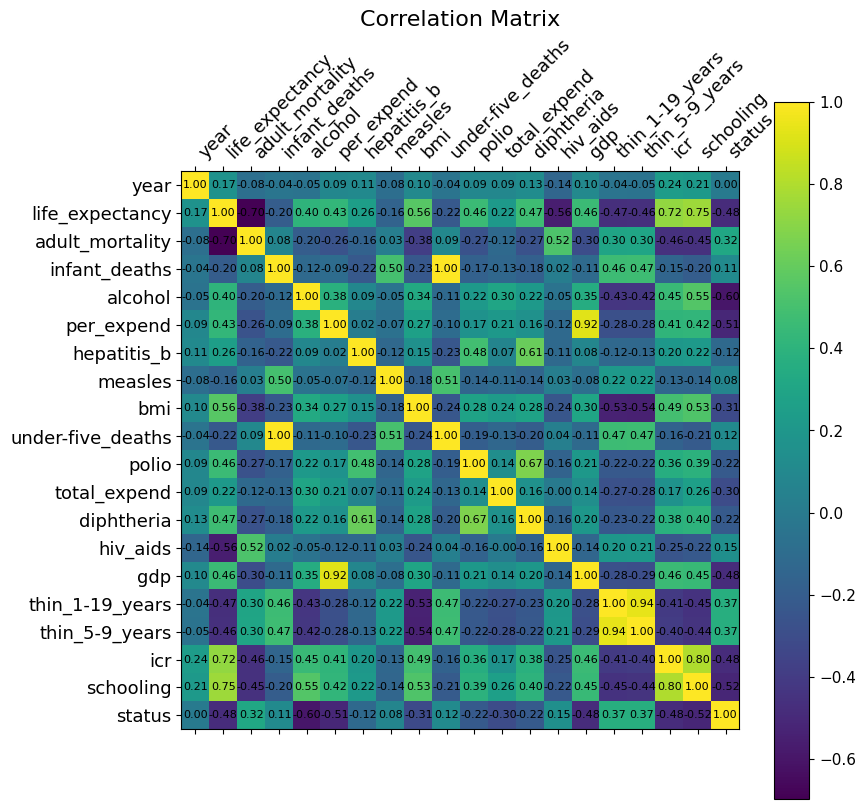

In [17]:
f = plt.figure(figsize=(9, 9))
mat = new_df.corr(numeric_only=True)
plt.matshow(mat, fignum=f.number)
for (i, j), z in np.ndenumerate(mat):
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', fontsize=8)
plt.xticks(range(new_df.select_dtypes(['number']).shape[1]), new_df.select_dtypes(['number']).columns, fontsize=13, ha="left", rotation=45)
plt.yticks(range(new_df.select_dtypes(['number']).shape[1]), new_df.select_dtypes(['number']).columns, fontsize=13)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=11)
plt.title('Correlation Matrix', fontsize=16)

This is the function that uses the linear regression model to predict the missing values of a feature by using predicators with high correlation to that feature.

In [18]:
def linear_regression_for_missing_value(predicator, target, df):
    df_with_nan = df[df.loc[:, [target]].isna().any(axis=1)]
    # Split training data
    df_without_nan = df[df.loc[:, [target]].notna().all(axis=1)]
    # Prepare predictor
    train_x = df_without_nan.loc[:, predicator]
    # Prepare target
    train_y = df_without_nan.loc[:, [target]]
    # Load Linear Regression model instance
    linear_regression = LinearRegression().fit(train_x, train_y)
    # Prepare test predictor
    test_x = df_with_nan.loc[:, predicator]
    # Train and predict
    test_y = linear_regression.predict(test_x)
    # Substitue prediction values into the dataframe to replace the NaN
    df.loc[df.loc[:, [target]].isna().any(axis=1), [target]] = test_y
    
    return df

By looking up the correlation matrix, I noticed that hepatitis_b has a high correlation with:
- diphtheria: 0.61
- polio: 0.48

In [19]:
new_df = linear_regression_for_missing_value(['diphtheria', 'polio'], 'hepatitis_b', new_df)
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
gdp                  443
total_expend         226
alcohol              193
schooling            160
icr                  160
country                0
thin_5-9_years         0
thin_1-19_years        0
hiv_aids               0
diphtheria             0
under-five_deaths      0
polio                  0
year                   0
bmi                    0
measles                0
hepatitis_b            0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

By looking up the correlation matrix, I noticed that schooling has a high correlation with:
- bmi: 0.53
- thin_1-19_years: -0.45
- thin_5-9_years: -0.44
- status: -0.52
- adult_mortality: -0.45

In [20]:
new_df = linear_regression_for_missing_value(['bmi', 'thin_1-19_years', 'thin_5-9_years', 'status',
                                              'adult_mortality'], 'schooling', new_df)
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
gdp                  443
total_expend         226
alcohol              193
icr                  160
country                0
schooling              0
thin_5-9_years         0
thin_1-19_years        0
hiv_aids               0
diphtheria             0
under-five_deaths      0
polio                  0
year                   0
bmi                    0
measles                0
hepatitis_b            0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

By looking up the correlation matrix, I noticed that icr has a high correlation with:
- bmi: 0.49
- thin_1-19_years: -0.41
- status: -0.48
- adult_mortality: -0.46
- schooling: 0.80

In [21]:
new_df = linear_regression_for_missing_value(['bmi', 'thin_1-19_years', 'schooling', 'status',
                                              'adult_mortality'], 'icr', new_df)
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
gdp                  443
total_expend         226
alcohol              193
country                0
schooling              0
icr                    0
thin_5-9_years         0
thin_1-19_years        0
hiv_aids               0
diphtheria             0
under-five_deaths      0
polio                  0
year                   0
bmi                    0
measles                0
hepatitis_b            0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

By looking up the correlation matrix, I noticed that alcohol has a high correlation with:
- thin_1-19_years: -0.43
- thin_5-9_years: -0.42
- status: -0.60

In [22]:
new_df = linear_regression_for_missing_value(['thin_1-19_years', 'thin_5-9_years', 'status'],
                                             'alcohol', new_df)
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
gdp                  443
total_expend         226
country                0
polio                  0
schooling              0
icr                    0
thin_5-9_years         0
thin_1-19_years        0
hiv_aids               0
diphtheria             0
under-five_deaths      0
year                   0
bmi                    0
measles                0
hepatitis_b            0
alcohol                0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

By looking up the correlation matrix, I noticed that gdp has a high correlation with:
- status: -0.48
- icr: 0.46
- schooling: 0.45

In [23]:
new_df = linear_regression_for_missing_value(['icr', 'schooling', 'status'], 'gdp', new_df)
new_df.isna().sum().sort_values(ascending=False)

per_expend           606
total_expend         226
country                0
polio                  0
schooling              0
icr                    0
thin_5-9_years         0
thin_1-19_years        0
gdp                    0
hiv_aids               0
diphtheria             0
under-five_deaths      0
year                   0
bmi                    0
measles                0
hepatitis_b            0
alcohol                0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

By looking up the correlation matrix, I noticed that per_expend has a high correlation with:
- gdp: 0.92
- icr: 0.41
- schooling: 0.42
- status: -0.51

In [24]:
new_df = linear_regression_for_missing_value(['gdp', 'icr', 'schooling', 'status'], 
                                             'per_expend', new_df)
new_df.isna().sum().sort_values(ascending=False)

total_expend         226
country                0
polio                  0
schooling              0
icr                    0
thin_5-9_years         0
thin_1-19_years        0
gdp                    0
hiv_aids               0
diphtheria             0
under-five_deaths      0
year                   0
bmi                    0
measles                0
hepatitis_b            0
per_expend             0
alcohol                0
infant_deaths          0
adult_mortality        0
life_expectancy        0
status                 0
dtype: int64

Since the last feature with empty values, total_expend, does not have any significant correlation with any of the other features, I choose to fill these NaN values with mean to be as representative as possible.

In [25]:
new_df['total_expend'] = new_df['total_expend'].fillna(new_df['total_expend'].mean())
new_df.isna().sum().sort_values(ascending=False)

country              0
polio                0
schooling            0
icr                  0
thin_5-9_years       0
thin_1-19_years      0
gdp                  0
hiv_aids             0
diphtheria           0
total_expend         0
under-five_deaths    0
year                 0
bmi                  0
measles              0
hepatitis_b          0
per_expend           0
alcohol              0
infant_deaths        0
adult_mortality      0
life_expectancy      0
status               0
dtype: int64

## 5.2 Feature Engineering Strategy - Dealing with outliers

After observing the correlation matrix, I noticed that the top three influential features on life_expectancy are the following:
1. schooling: 0.75
2. icr: 0.72
3. adult_mortality: -0.70


Therefore, I choose to modify the outliers only for these features. The boxplots (same order as the list) below shows the outliers:

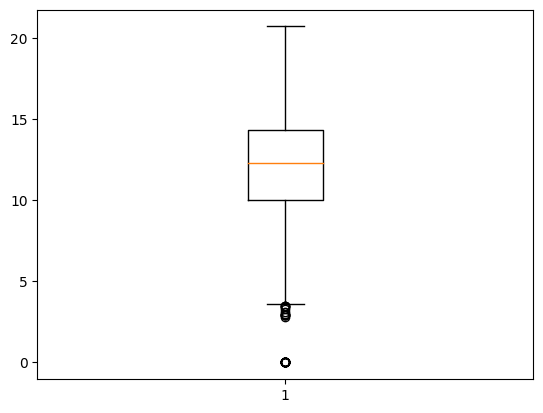

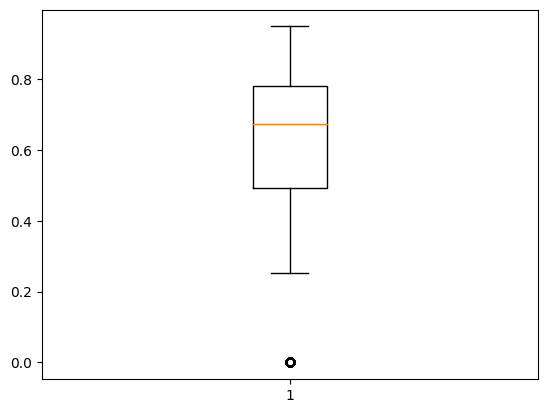

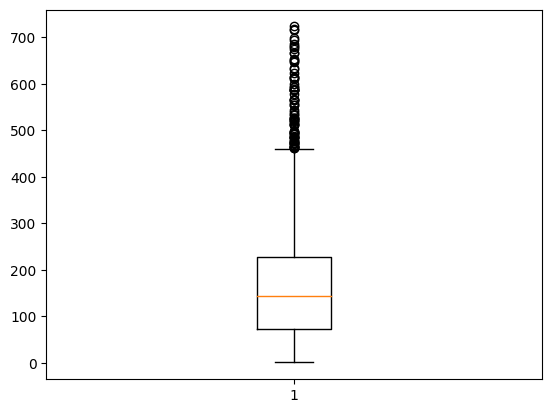

In [26]:
plt.boxplot(new_df['schooling'])
plt.show()

plt.boxplot(new_df['icr'])
plt.show()

plt.boxplot(new_df['adult_mortality'])
plt.show()

I choose the inter quantile range method to identify outliers. I first calculate the first quantile and thrid quantile to determine the inter quantile range. 
- Lower boundary = first quantile - 1.3 times of the interquantile range
- Upper boundary = thrid quantile + 1.3 times of the interquantile range. 

The threshold 1.3 is finetuned for the best performance.

In [27]:
thres = 1.3

for feature in ['schooling', 'icr', 'adult_mortality']:
    data = new_df[feature]
    
    # Calculate the Inter Quantile Range
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    inter_quantile_range = q3 - q1

    # Remove any data points with a value above the upper threshold or below the lower threshold
    new_df = new_df[(new_df[feature] >= q1 - thres*inter_quantile_range)
                    & (new_df[feature] <= q3 + thres*inter_quantile_range)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2640 entries, 0 to 2809
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   country            2640 non-null   category
 1   year               2640 non-null   int64   
 2   life_expectancy    2640 non-null   float64 
 3   adult_mortality    2640 non-null   float64 
 4   infant_deaths      2640 non-null   int64   
 5   alcohol            2640 non-null   float64 
 6   per_expend         2640 non-null   float64 
 7   hepatitis_b        2640 non-null   float64 
 8   measles            2640 non-null   int64   
 9   bmi                2640 non-null   float64 
 10  under-five_deaths  2640 non-null   int64   
 11  polio              2640 non-null   float64 
 12  total_expend       2640 non-null   float64 
 13  diphtheria         2640 non-null   float64 
 14  hiv_aids           2640 non-null   float64 
 15  gdp                2640 non-null   float64 
 16  thin_1

As shown in the same boxplots below, the outliers have been successfully removed.

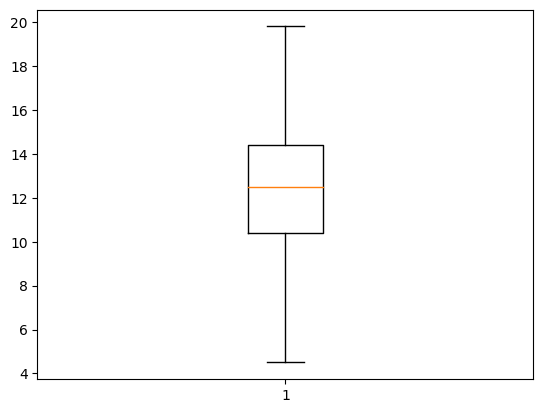

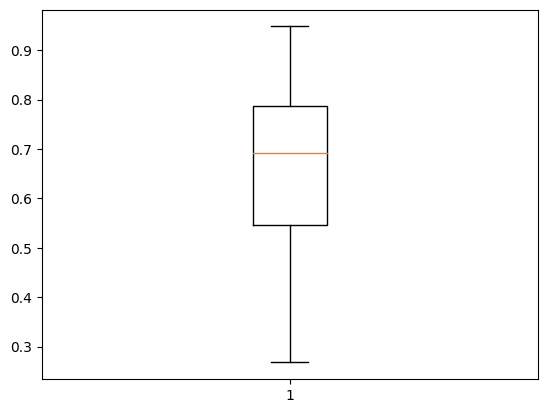

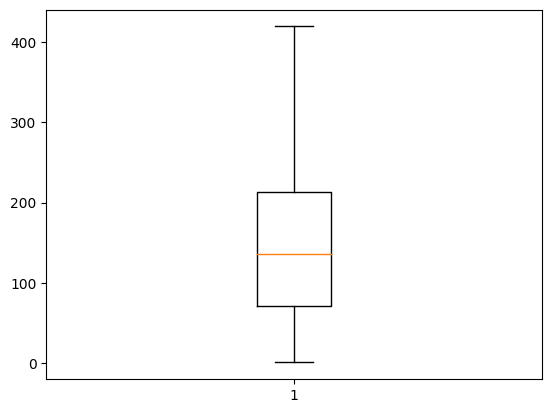

In [28]:
plt.boxplot(new_df['schooling'])
plt.show()

plt.boxplot(new_df['icr'])
plt.show()

plt.boxplot(new_df['adult_mortality'])
plt.show()

## 5.3 Performing linear regression

In [29]:
train, test = train_test_split(new_df, test_size=0.2, random_state=47)
# Prepare predictor
train_x = train.drop(columns=['country', 'life_expectancy'])
# Prepare target
train_y = train['life_expectancy']
# Prepare test predictor
test_x = test.drop(columns=['country', 'life_expectancy'])
# Prepare target
test_y = test['life_expectancy']

# Load Linear Regression model instance
linear_regression = LinearRegression().fit(train_x, train_y)
# Train and predict
test_predict = linear_regression.predict(test_x)

# Calculate evaluation metrics
r2 = r2_score(test_y, test_predict)
rmse = mean_squared_error(test_y, test_predict)
# MSE the lower the better
# R2 the higher the better
new_metrics = pd.DataFrame({'Model': ['My Revised Model'], 'R^2 Score': [r2], 
                            'Mean Square Error': [rmse]})
df_metrics = pd.concat([df_metrics, new_metrics], ignore_index=True)

df_metrics

,Model,R^2 Score,Mean Square Error
0,Simple Linear,0.538070,38.185284
1,PCA + Linear,0.749141,20.737165
2,My Revised Model,0.848344,9.824510


# 6 Conclusion
As displayed in the table above, my revised model shows a superior performance in comparsion to the first two models. Therefore, it can be concluded that my data cleansing and feature engineering strategies are effective in improving the performance of the linear regression model in terms of the R^2 Score and Mean Square Error.